# Settings

In [1]:
import sys

# set lib path just next to current path to give priority to modules in lib
sys.path.insert(sys.path.index('')+1, '/lib')

In [2]:
%load_ext autotime

import pandas as pd
import FinanceDataReader as fdr

from lib.fastquant import backtest_portfolio
from lib.utils import HiddenPrints, DATE_FORMAT
from datetime import datetime, timedelta

from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import numpy as np

time: 9.69 s (started: 2023-03-01 23:18:27 +09:00)


In [3]:
def run_backtest(start, df_bt, kwargs, proba=1, strategy='custom'):
    
    df = df_bt.copy()
    end = start + timedelta(hold_period)
    df = df.loc[start:end]
    if proba < 1:
        df.loc[:,'custom'] = df.custom.apply(lambda x:x*np.random.choice(2, 1, p=[1.-proba, proba])[0])
    df = {symbol: df}
    with HiddenPrints(mark_end=False):
        result = backtest_portfolio(strategy, df, start.strftime(DATE_FORMAT), end.strftime(DATE_FORMAT), **kwargs)
    #return result # testing
        
    #if np.isnan(result['history']['win_rate'].squeeze()):
    if result['history']['total'].squeeze() == 0:
        #return [start, end, None, None, None] # last col 'return' cast to NaT instead of None 
        return [start, end, -1, None, None]
    else:
        return [start, end] + result['summary']
    

def print_progress(i, print_step, last_print):
    n = round((i+1) / n_dates * 100)
    if n != last_print and n % (print_step*100) == 0:
        print(f'{n}% done')
        return n
    else:
        return last_print
    
    
def compare_models(df, ret_limit=None, figsize=(14, 5), width_ratios=[3, 1],
                   title="Strategy Comparison", orient='v'):
    
    kw_box = {'h': dict(y='scenario', x='return'),
             'v': dict(x='scenario', y='return')}
    kw_axline = dict(lw=1, ls='--', c='dimgray')

    fig = plt.figure(figsize=figsize)
    fig.suptitle(title)
    gs = GridSpec(1, 2, width_ratios=width_ratios)
    ax1 = fig.add_subplot(gs[0])
    #ax2 = fig.add_subplot(gs[1], sharey=ax1)
    ax2 = fig.add_subplot(gs[1])
    #fig.tight_layout()

    df = df.dropna(subset='return').reset_index()
    _ = sns.lineplot(data=df, x='start', y='return', hue='scenario', ax=ax1, lw=0.5)
    _ = sns.boxplot(data=df, ax=ax2, orient=orient, **kw_box[orient])

    _ = ax1.axhline(**kw_axline)
    _ = ax1.set_ylim(top=ret_limit)
    if orient == 'h':
        _ = ax2.axvline(**kw_axline)
        _ = ax2.set_xlim(right=ret_limit)
    else:
        _ = ax2.axhline(**kw_axline)
        _ = ax2.set_ylim(top=ret_limit)

time: 7.36 ms (started: 2023-03-01 23:18:37 +09:00)


In [4]:
import tulipy as ti


def calc_macd(df, periods=[12,26,9]):
    ind = ti.macd(df.astype(float).to_numpy(), *periods)

    name = 'macd'
    cols = [name, name+'_signal', name+'_histogram']
    
    index_size = len(df.index)
    indi = np.full((len(cols), index_size), np.nan)
    indi[:, index_size-ind[0].size:] = ind
    
    return pd.DataFrame(dict(zip(cols, indi)), index=df.index)


def calc_bbands(df, periods=[20,2]):
    ind = ti.bbands(df.astype(float).to_numpy(), *periods)

    name = 'bbands'
    cols = [name+'_lower', name+'_middle', name+'_upper']
    
    index_size = len(df.index)
    indi = np.full((len(cols), index_size), np.nan)
    indi[:, index_size-ind[0].size:] = ind
    
    return pd.DataFrame(dict(zip(cols, indi)), index=df.index)


def finish_custom(df_bt):
    df = df_bt.copy()
    prv = 0
    for dt, (_, c) in df.iterrows():
        if c in [1, -1]:
            if c == prv:
                df.loc[dt, 'custom'] = 0
            else:
                prv = c
        else:
            prv = 0
    return df


def check_scenario(idx_nobuy, i=None, df_result=None):
    if df_result is None:
        n = len(idx_nobuy)
        if n > 0:
            print(f'{n} scenarios of no buy.')
        return None
    if pd.isnull(df_result.loc[i]['return']):
        idx_nobuy.append(i)
        n = len(idx_nobuy)
        if n < 2:
            print(f'{i}: No buy at all')
        elif n == 2:
            print('there are more scenarios of no buy.')
        else:
            pass
    return idx_nobuy

time: 22.7 ms (started: 2023-03-01 23:18:37 +09:00)


In [ ]:
start = '20180101'
end = '20221231'

symbol = '069500' # KODEX 200
df_all = fdr.DataReader(symbol, start, end)

In [ ]:
df_compare = pd.DataFrame()

# Buy & hold

## Settings

In [7]:
df_bt = (df_all.Close.rename_axis('dt').to_frame('close')
               .assign(custom=0))
dates_all = df_bt.index

time: 12.8 ms (started: 2023-02-28 18:29:39 +09:00)


In [8]:
hold_period = 365
dates_start = df_bt.loc[: dates_all[-1] - timedelta(hold_period)].index
n_dates = dates_start.size

time: 8.97 ms (started: 2023-02-28 18:29:40 +09:00)


In [9]:
kwargs_bt = {
    'init_cash': 1e7, 
    'commission': 0.00363960/100,
    'verbose': False, 
    'plot_bp':False,
    'buy_prop': 1,
    'sell_prop': 1,
    'upper_limit':0.1, 
    'lower_limit':-0.1
}

time: 6.83 ms (started: 2023-02-28 18:29:41 +09:00)


## SC01

In [10]:
scenario = 'b1'
n_buy = 1

kwargs_bt.update({
    'buy_prop': 1/n_buy,
})

time: 1.03 ms (started: 2023-02-28 18:29:42 +09:00)


In [11]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0

for i, start in enumerate(dates_start):
    df_bt['custom'] = 0 # reset
    df_bt.loc[start,'custom'] = -1
    
    res = run_backtest(start, df_bt, kwargs_bt)
    if res[2] <= 0:
        print('ERROR: no buy for buy&hold')
        break
    df_result.loc[i] = res
    
    n_last = print_progress(i, print_step, n_last)

10% done
20% done
30% done
40% done
50% done
60% done
70% done
80% done
90% done
100% done
time: 13min 5s (started: 2023-02-28 18:29:43 +09:00)


In [12]:
df_result['return'].agg(['mean','min','max'])

mean      7.878639
min     -29.578320
max     111.056006
Name: return, dtype: float64

time: 13.5 ms (started: 2023-02-28 18:42:49 +09:00)


In [13]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 13.7 ms (started: 2023-02-28 18:42:49 +09:00)


## SC02

In [14]:
scenario = 'b2'
n_buy = 10

kwargs_bt.update({
    'buy_prop': 1/n_buy,
})

time: 4.29 ms (started: 2023-02-28 18:42:49 +09:00)


In [15]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0

period = 20

for i, start in enumerate(dates_start):
    df_bt['custom'] = 0 # reset
    dt = dates_all[[i + x*period for x in range(n_buy)]]
    df_bt.loc[dt,'custom'] = -1
    
    res = run_backtest(start, df_bt, kwargs_bt)
    if res[2] <= 0:
        print('ERROR: no buy for buy&hold')
        break
    df_result.loc[i] = res
    n_last = print_progress(i, print_step, n_last)

10% done
20% done
30% done
40% done
50% done
60% done
70% done
80% done
90% done
100% done
time: 13min 59s (started: 2023-02-28 18:42:49 +09:00)


In [16]:
df_result['return'].agg(['mean','min','max'])

mean     3.414606
min    -16.512425
max     38.402674
Name: return, dtype: float64

time: 11.1 ms (started: 2023-02-28 18:56:49 +09:00)


In [17]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 14.6 ms (started: 2023-02-28 18:56:49 +09:00)


## SC03

In [18]:
scenario = 'b3'
n_buy = 20

kwargs_bt.update({
    'buy_prop': 1/n_buy,
})

time: 1.17 ms (started: 2023-02-28 18:56:49 +09:00)


In [19]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0

period = 10

for i, start in enumerate(dates_start):
    df_bt['custom'] = 0 # reset
    dt = dates_all[[i + x*period for x in range(n_buy)]]
    df_bt.loc[dt,'custom'] = -1
    
    res = run_backtest(start, df_bt, kwargs_bt)
    if res[2] <= 0:
        print('ERROR: no buy for buy&hold')
        break
    df_result.loc[i] = res
    n_last = print_progress(i, print_step, n_last)

10% done
20% done
30% done
40% done
50% done
60% done
70% done
80% done
90% done
100% done
time: 15min 19s (started: 2023-02-28 18:56:49 +09:00)


In [20]:
df_result['return'].agg(['mean','min','max'])

mean     3.217287
min    -16.298809
max     36.433602
Name: return, dtype: float64

time: 18.9 ms (started: 2023-02-28 19:12:08 +09:00)


In [21]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 11.7 ms (started: 2023-02-28 19:12:08 +09:00)


In [23]:
df_compare.to_csv('df_compare1_tmp.csv')

time: 85.4 ms (started: 2023-02-28 19:12:09 +09:00)


## Compare

In [55]:
df = df_compare.loc[df_compare.scenario.str.startswith('b')]

time: 12.4 ms (started: 2023-03-01 09:32:03 +09:00)


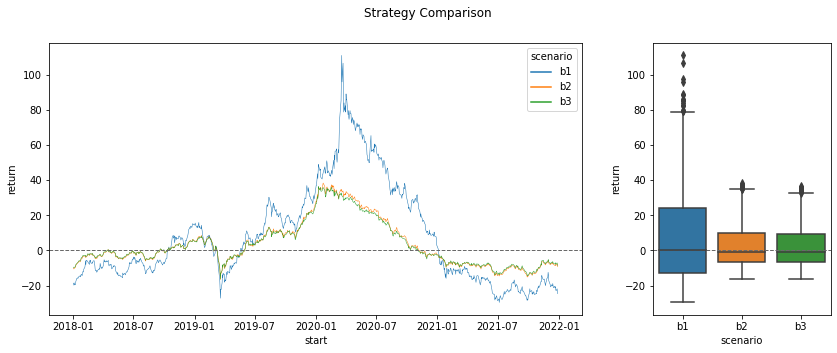

time: 1.26 s (started: 2023-03-01 09:32:04 +09:00)


In [56]:
compare_models(df)

# Technical Indicator

## Settings

In [26]:
df_bt_ori = (df_all.Close.rename_axis('dt').to_frame('close')
               .assign(custom=0))
dates_all = df_bt_ori.index

time: 6.73 ms (started: 2023-02-28 19:17:15 +09:00)


In [27]:
hold_period = 365
dates_start = df_bt_ori.loc[: dates_all[-1] - timedelta(hold_period)].index
n_dates = dates_start.size

time: 1.99 ms (started: 2023-02-28 19:17:18 +09:00)


In [28]:
kwargs_bt = {
    'init_cash': 1e7, 
    'commission': 0.00363960/100,
    'verbose': False, 
    'plot_bp':False,
    'buy_prop': 1,
    'sell_prop': 1,
    'upper_limit':0.1, 
    'lower_limit':-0.1
}

time: 980 µs (started: 2023-02-28 19:17:27 +09:00)


In [29]:
# testing
#dates_start = dates_start[400:500]

time: 574 µs (started: 2023-02-28 19:17:29 +09:00)


## SC01: MACD

### calc tech indi

In [30]:
df_bt = df_bt_ori.copy()
df_macd = calc_macd(df_bt['close'])

time: 9.54 ms (started: 2023-02-28 19:17:32 +09:00)


In [31]:
df_ti = df_macd

cond = (df_ti.macd > df_ti.macd_signal) 
cond = cond & (df_ti.macd > 0)
df_bt.loc[cond, 'custom'] = -1

cond = (df_ti.macd < df_ti.macd_signal) 
cond = cond & (df_ti.macd < 0)
df_bt.loc[cond, 'custom'] = 1

time: 8.57 ms (started: 2023-02-28 19:17:33 +09:00)


In [32]:
df_bt = finish_custom(df_bt)

time: 380 ms (started: 2023-02-28 19:17:34 +09:00)


In [33]:
# small number of chance to buy
df_bt.custom.value_counts()

 0    1161
 1      38
-1      33
Name: custom, dtype: int64

time: 17.1 ms (started: 2023-02-28 19:17:35 +09:00)


### bactesting 1

In [34]:
scenario = 't1a'

kwargs_bt.update({
    'buy_prop': 1,
    'sell_prop': 1
})

time: 979 µs (started: 2023-02-28 19:18:21 +09:00)


In [35]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0
idx_nobuy = []

for i, start in enumerate(dates_start):
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    n_last = print_progress(i, print_step, n_last)
    idx_nobuy = check_scenario(idx_nobuy, i, df_result)

check_scenario(idx_nobuy)

10% done
20% done
30% done
40% done
50% done
60% done
70% done
80% done
90% done
100% done
time: 16min 37s (started: 2023-02-28 19:18:29 +09:00)


In [36]:
df_result['return'].agg(['mean','min','max'])

mean     8.054669
min    -12.013608
max     57.532363
Name: return, dtype: float64

time: 13.5 ms (started: 2023-02-28 19:35:07 +09:00)


In [37]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 9.51 ms (started: 2023-02-28 19:35:07 +09:00)


### bactesting 2

In [38]:
scenario = 't1b'

kwargs_bt.update({
    'buy_prop': 0.5,
    'sell_prop': 0.5
})

time: 1.13 ms (started: 2023-02-28 19:35:07 +09:00)


In [39]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0
idx_nobuy = []

for i, start in enumerate(dates_start):
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    n_last = print_progress(i, print_step, n_last)
    idx_nobuy = check_scenario(idx_nobuy, i, df_result)

check_scenario(idx_nobuy)

10% done
20% done
30% done
40% done
50% done
60% done
70% done
80% done
90% done
100% done
time: 19min 3s (started: 2023-02-28 19:35:07 +09:00)


In [40]:
df_result['return'].agg(['mean','min','max'])

mean     4.636345
min     -6.153420
max     36.403294
Name: return, dtype: float64

time: 11.4 ms (started: 2023-02-28 19:54:10 +09:00)


In [41]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 11 ms (started: 2023-02-28 19:54:10 +09:00)


### bactesting 3

In [42]:
scenario = 't1c'

kwargs_bt.update({
    'buy_prop': 0.2,
    'sell_prop': 0.2
})

time: 1.02 ms (started: 2023-02-28 19:54:10 +09:00)


In [43]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0
idx_nobuy = []

for i, start in enumerate(dates_start):
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    n_last = print_progress(i, print_step, n_last)
    idx_nobuy = check_scenario(idx_nobuy, i, df_result)

check_scenario(idx_nobuy)

10% done
20% done
30% done
40% done
50% done
60% done
70% done
80% done
90% done
100% done
time: 21min 33s (started: 2023-02-28 19:54:10 +09:00)


In [44]:
df_result['return'].agg(['mean','min','max'])

mean     1.854880
min     -3.162596
max     16.136710
Name: return, dtype: float64

time: 11.8 ms (started: 2023-02-28 20:15:44 +09:00)


In [45]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 9.13 ms (started: 2023-02-28 20:15:44 +09:00)


### bactesting 4

In [46]:
scenario = 't1d'

kwargs_bt.update({
    'buy_prop': 1,
    'sell_prop': 1
})

proba = 0.8

time: 1.17 ms (started: 2023-02-28 20:15:44 +09:00)


In [47]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0
idx_nobuy = []

for i, start in enumerate(dates_start):
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt, proba)
    n_last = print_progress(i, print_step, n_last)
    idx_nobuy = check_scenario(idx_nobuy, i, df_result)

check_scenario(idx_nobuy)

10% done
105: No buy at all
20% done
30% done
40% done
50% done
60% done
70% done
80% done
90% done
there are more scenarios of no buy.
100% done
2 scenarios of no buy.
time: 25min 25s (started: 2023-02-28 20:15:44 +09:00)


In [48]:
df_result['return'].agg(['mean','min','max'])

mean     7.139184
min    -28.178184
max     63.350118
Name: return, dtype: float64

time: 20.4 ms (started: 2023-02-28 20:41:10 +09:00)


In [49]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 20.1 ms (started: 2023-02-28 20:41:10 +09:00)


In [50]:
df_compare.to_csv('df_compare1_tmp2.csv')

time: 182 ms (started: 2023-02-28 20:41:10 +09:00)


### compare

In [57]:
df = df_compare.loc[df_compare.scenario.str.startswith('t1')]

time: 18.4 ms (started: 2023-03-01 09:32:12 +09:00)


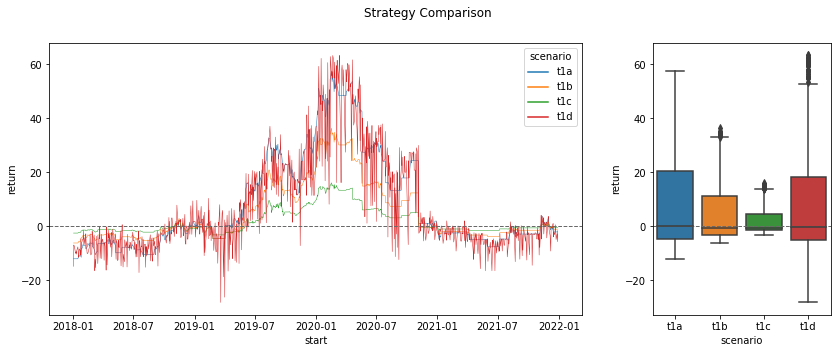

time: 1.33 s (started: 2023-03-01 09:32:13 +09:00)


In [58]:
compare_models(df)

## SC02: Bollinger Bands

### calc tech indi

In [52]:
df_bt = df_bt_ori.copy()
df_bbands = calc_bbands(df_bt['close'])
#df_bbands = calc_bbands(df_bt['close'], [20, 1])

time: 5.59 ms (started: 2023-02-28 20:41:12 +09:00)


In [53]:
df_ti = df_bbands

cond = df_bt.close < df_ti.bbands_lower
df_bt.loc[cond, 'custom'] = -1

cond = df_bt.close > df_ti.bbands_upper
df_bt.loc[cond, 'custom'] = 1

time: 6.91 ms (started: 2023-02-28 20:41:12 +09:00)


In [54]:
df_bt = finish_custom(df_bt)

time: 191 ms (started: 2023-02-28 20:41:12 +09:00)


In [55]:
df_bt.custom.value_counts()

 0    1157
-1      42
 1      33
Name: custom, dtype: int64

time: 11 ms (started: 2023-02-28 20:41:12 +09:00)


### bactesting 1

In [56]:
scenario = 't2a'

kwargs_bt.update({
    'buy_prop': 1,
    'sell_prop': 1
})

time: 988 µs (started: 2023-02-28 20:41:12 +09:00)


In [57]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0
idx_nobuy = []

for i, start in enumerate(dates_start):
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    n_last = print_progress(i, print_step, n_last)
    idx_nobuy = check_scenario(idx_nobuy, i, df_result)

check_scenario(idx_nobuy)

10% done
20% done
30% done
40% done
50% done
60% done
70% done
80% done
90% done
100% done
time: 28min 46s (started: 2023-02-28 20:41:12 +09:00)


In [58]:
df_result['return'].agg(['mean','min','max'])

mean    -1.312248
min    -25.756412
max     20.074891
Name: return, dtype: float64

time: 12.7 ms (started: 2023-02-28 21:09:59 +09:00)


In [59]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 11.4 ms (started: 2023-02-28 21:09:59 +09:00)


### bactesting 2

In [60]:
scenario = 't2b'

kwargs_bt.update({
    'buy_prop': 0.5,
    'sell_prop': 0.5
})

time: 993 µs (started: 2023-02-28 21:09:59 +09:00)


In [61]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0
idx_nobuy = []

for i, start in enumerate(dates_start):
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    n_last = print_progress(i, print_step, n_last)
    idx_nobuy = check_scenario(idx_nobuy, i, df_result)

check_scenario(idx_nobuy)

10% done
20% done
30% done
40% done
50% done
60% done
70% done
80% done
90% done
100% done
time: 33min 41s (started: 2023-02-28 21:09:59 +09:00)


In [62]:
df_result['return'].agg(['mean','min','max'])

mean    -1.386416
min    -24.544178
max     13.952202
Name: return, dtype: float64

time: 10.1 ms (started: 2023-02-28 21:43:41 +09:00)


In [63]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 23.7 ms (started: 2023-02-28 21:43:41 +09:00)


### bactesting 3

In [64]:
scenario = 't2c'

kwargs_bt.update({
    'buy_prop': 0.2,
    'sell_prop': 0.2
})

time: 1.4 ms (started: 2023-02-28 21:43:41 +09:00)


In [65]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0
idx_nobuy = []

for i, start in enumerate(dates_start):
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    n_last = print_progress(i, print_step, n_last)
    idx_nobuy = check_scenario(idx_nobuy, i, df_result)

check_scenario(idx_nobuy)

10% done
20% done
30% done
40% done
50% done
60% done
70% done
80% done
90% done
100% done
time: 38min 58s (started: 2023-02-28 21:43:41 +09:00)


In [66]:
df_result['return'].agg(['mean','min','max'])

mean    -1.476501
min    -20.921568
max      6.389692
Name: return, dtype: float64

time: 12 ms (started: 2023-02-28 22:22:39 +09:00)


In [67]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 13 ms (started: 2023-02-28 22:22:39 +09:00)


### bactesting 4

In [68]:
scenario = 't2d'

kwargs_bt.update({
    'buy_prop': 0.2,
    'sell_prop': 0.2
})

proba = 0.5

time: 1.16 ms (started: 2023-02-28 22:22:40 +09:00)


In [69]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0
idx_nobuy = []

for i, start in enumerate(dates_start):
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt, proba)
    n_last = print_progress(i, print_step, n_last)
    idx_nobuy = check_scenario(idx_nobuy, i, df_result)

check_scenario(idx_nobuy)

8: No buy at all
10% done
20% done
there are more scenarios of no buy.
30% done
40% done
50% done
60% done
70% done
80% done
90% done
100% done
20 scenarios of no buy.
time: 45min 27s (started: 2023-02-28 22:22:40 +09:00)


In [70]:
df_result['return'].agg(['mean','min','max'])

mean    -1.315268
min    -19.091197
max     16.680429
Name: return, dtype: float64

time: 28 ms (started: 2023-02-28 23:08:07 +09:00)


In [71]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 18.8 ms (started: 2023-02-28 23:08:07 +09:00)


In [72]:
df_compare.to_csv('df_compare1_tmp3.csv')

time: 312 ms (started: 2023-02-28 23:08:07 +09:00)


### compare

In [59]:
df = df_compare.loc[df_compare.scenario.str.startswith('t2')]

time: 20.9 ms (started: 2023-03-01 09:32:22 +09:00)


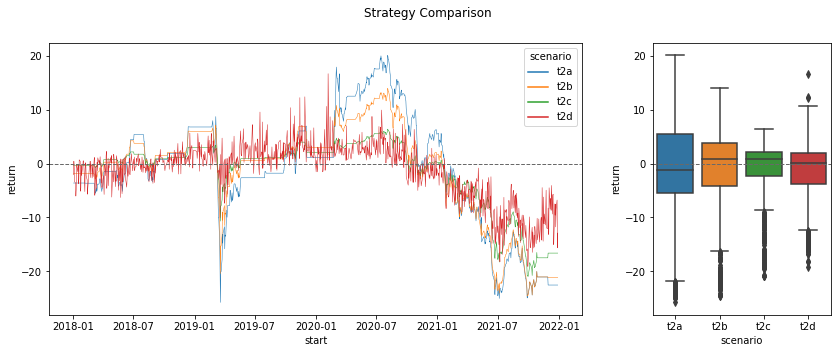

time: 1.36 s (started: 2023-03-01 09:32:23 +09:00)


In [60]:
compare_models(df)

## SC03: Bollinger Bands & MACD

### calc tech indi

In [74]:
df_bt = df_bt_ori.copy()
df_macd = calc_macd(df_bt['close'])
df_bbands = calc_bbands(df_bt['close'])

time: 23.2 ms (started: 2023-02-28 23:08:09 +09:00)


In [75]:
cond = (df_macd.macd > df_macd.macd_signal) & (df_macd.macd > 0)
cond = cond + (df_bt.close < df_bbands.bbands_lower)
df_bt.loc[cond, 'custom'] = -1

cond = (df_macd.macd < df_macd.macd_signal) & (df_macd.macd < 0)
cond = cond + (df_bt.close > df_bbands.bbands_lower)
df_bt.loc[cond, 'custom'] = 1

time: 12.2 ms (started: 2023-02-28 23:08:09 +09:00)


In [76]:
df_bt = finish_custom(df_bt)

time: 597 ms (started: 2023-02-28 23:08:09 +09:00)


In [77]:
df_bt.custom.value_counts()

 0    1207
 1      13
-1      12
Name: custom, dtype: int64

time: 22.7 ms (started: 2023-02-28 23:08:10 +09:00)


### bactesting

In [78]:
scenario = 't3'

kwargs_bt.update({
    'buy_prop': 1,
    'sell_prop': 1
})

time: 2.72 ms (started: 2023-02-28 23:08:10 +09:00)


In [79]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0
idx_nobuy = []

for i, start in enumerate(dates_start):
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    n_last = print_progress(i, print_step, n_last)
    idx_nobuy = check_scenario(idx_nobuy, i, df_result)

check_scenario(idx_nobuy)

26: No buy at all
there are more scenarios of no buy.
10% done
20% done
30% done
40% done
50% done
60% done
70% done
80% done
90% done
100% done
16 scenarios of no buy.
time: 51min 29s (started: 2023-02-28 23:08:10 +09:00)


In [80]:
df_result['return'].agg(['mean','min','max'])

mean    2.108161
min    -1.706558
max     6.489749
Name: return, dtype: float64

time: 32 ms (started: 2023-02-28 23:59:40 +09:00)


In [81]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 88.7 ms (started: 2023-02-28 23:59:40 +09:00)


In [82]:
df_compare.to_csv('df_compare1.csv')

time: 359 ms (started: 2023-02-28 23:59:40 +09:00)


### compare

In [61]:
models = ['t1a', 't2a', 't3']
df = df_compare.loc[df_compare.scenario.isin(models)]

time: 9.95 ms (started: 2023-03-01 09:32:34 +09:00)


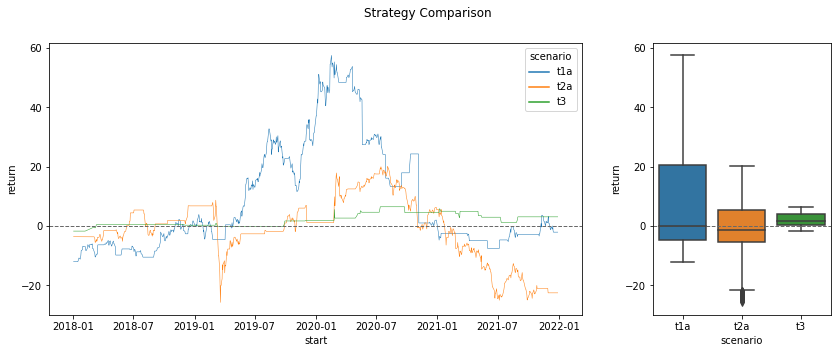

time: 1.2 s (started: 2023-03-01 09:32:35 +09:00)


In [62]:
compare_models(df)

# Comparison

## Visualization

In [6]:
df_compare = pd.read_csv('df_compare1.csv', index_col=0, parse_dates=['start'])
#df_compare

time: 37.4 ms (started: 2023-03-01 08:28:47 +09:00)


In [7]:
df_compare.groupby(by=['scenario']).agg(['mean','median','min','max','std','count'])

return                                                  
              mean    median        min         max        std count
scenario                                                            
b1        7.878639  0.402187 -29.578320  111.056006  27.575498   985
b2        3.414606 -0.903985 -16.512425   38.402674  13.113664   985
b3        3.217287 -0.755533 -16.298809   36.433602  12.425961   985
t1a       8.054669  0.013180 -12.013608   57.532364  17.799612   985
t1b       4.636345 -0.655828  -6.153420   36.403294  10.678585   985
t1c       1.854880 -0.513834  -3.162596   16.136710   4.728399   985
t1d       7.139184 -0.369959 -28.178184   63.350118  18.064121   983
t2a      -1.312248 -1.233531 -25.756412   20.074891  10.610954   985
t2b      -1.386416  0.792652 -24.544178   13.952202   9.154896   985
t2c      -1.476501  0.882640 -20.921568    6.389692   6.378838   985
t2d      -1.315268  0.048280 -19.091197   16.680429   5.232895   965
t3        2.108161  1.711919  -1.706558    6.489749   2.117371   969

time: 66.7 ms (started: 2023-03-01 08:28:49 +09:00)


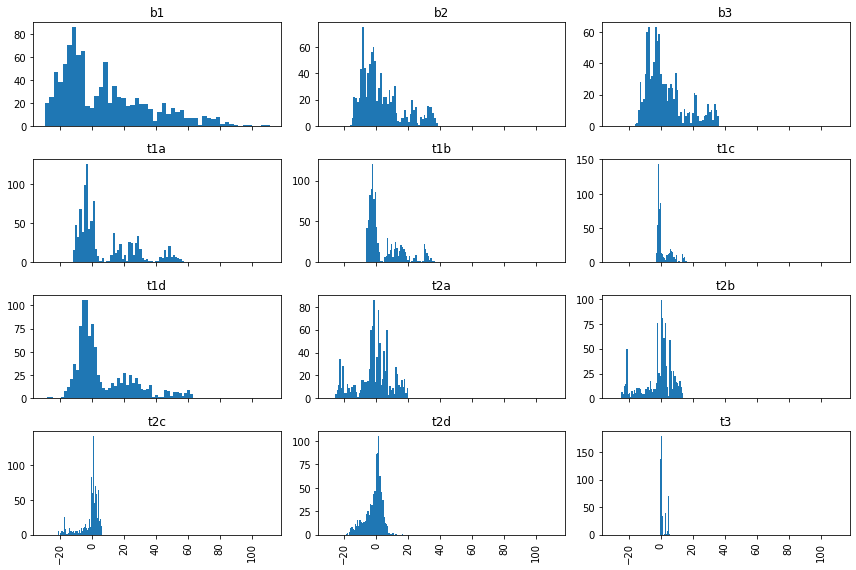

time: 7.62 s (started: 2023-03-01 08:28:50 +09:00)


In [8]:
_ = df_compare.hist(by='scenario', column='return', figsize=(12,8), bins=50, sharex=True)
plt.tight_layout()

In [63]:
df = (df_compare
      #.loc[df_compare.scenario.str.startswith('t2')]
      .loc[df_compare.scenario.isin(['b1', 't1a', 't2a', 't3'])]
     )

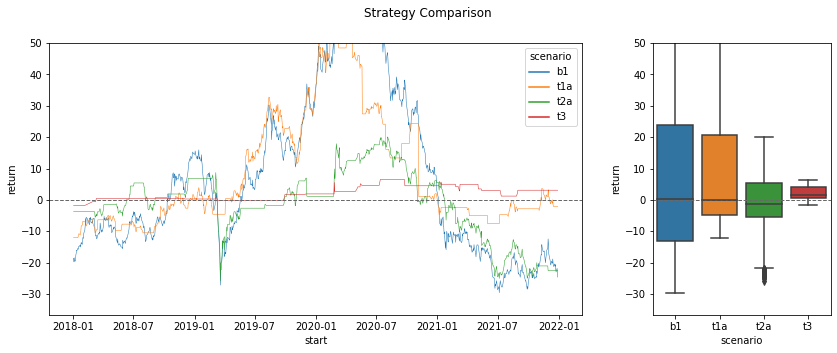

time: 1.42 s (started: 2023-03-01 09:32:45 +09:00)


In [63]:
#compare_models(df, 50, orient='h')
compare_models(df, 50)

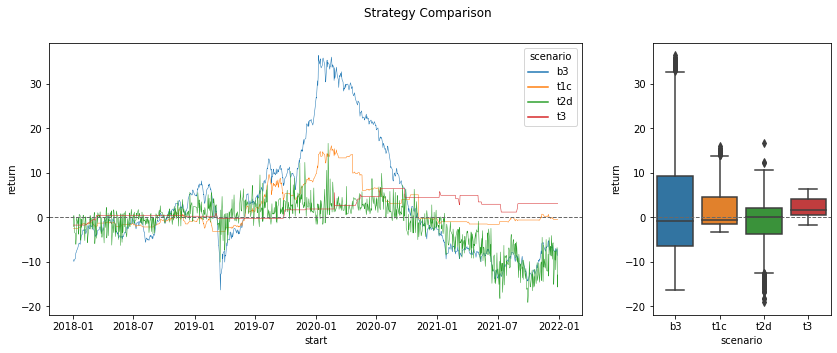

time: 1.36 s (started: 2023-03-01 09:33:18 +09:00)


In [64]:
models = ['b3', 't1c', 't2d', 't3']
df = df_compare.loc[df_compare.scenario.isin(models)]
     
compare_models(df)

## Bayesian estimation

### Settings

In [5]:
import pymc3 as pm
import arviz
from matplotlib import gridspec
from matplotlib.lines import Line2D
from scipy import stats

YEAR = 252
midx = pd.IndexSlice
DATE_FILE = '%y%m%d'


    
def bayesian_estimate(df_returns, draws=10000, tune=2500, burnin=0,
                      chains=4, target_accept=.9, inspect_mode=False, 
                      figsize=(10, 14), loc_legend='upper right',
                      plot_trace=True, save_plot=False, save_path=None):
    """
    Bayesian hypothesis test to compare two return distributions. 
    Returns are assumed to be T-distributed.
    can run with more than 2 return dists but no comparison then
    """
    if not isinstance(df_returns, pd.Series):
        print('ERROR: df_returns is not series')
        return
    else:
        df_returns = df_returns.dropna()
        lvl1, _ = df_returns.index.names
        
    # priors
    mean_prior, std_prior = df_returns.mean(), df_returns.std()
    std_low, std_high = std_prior / 1000, std_prior * 1000
    T = YEAR ** .5
    mean, std, returns = {}, {}, {}
    groups = df_returns.index.get_level_values(lvl1).unique()
    num_groups = len(groups) # flag to plot comparisio if comparing two hists
    
    with pm.Model() as model:
        nu = pm.Exponential('nu_minus_two', 1 / 29, testval=4) + 2.
        for i, g in enumerate(groups):
            df_g = df_returns.loc[midx[g]]
            mean[i] = pm.Normal(f'mean_{g}', mu=mean_prior, sd=std_prior, testval=df_g.mean())
            std[i] = pm.Uniform(f'std_{g}', lower=std_low, upper=std_high, testval=df_g.std())
            returns[i] = pm.StudentT(f'returns_{g}', nu=nu, mu=mean[i], sd=std[i], observed=df_g)
            pm.Deterministic(f'vol_{g}', returns[i].distribution.sd * T)
            pm.Deterministic(f'sharpe_{g}', returns[i].distribution.mean / returns[i].distribution.sd * T)
        if num_groups == 2:
            mean_diff = pm.Deterministic('mean diff', mean[0] - mean[1])
            pm.Deterministic('std diff', std[0] - std[1])
            pm.Deterministic('effect size', mean_diff / (std[0] ** 2 + std[1] ** 2) ** .5 / 2)

    if inspect_mode:
        pm.model_to_graphviz(model=model)

    with model:
        # HMC NUTS Sampling
        #cores, _ = print_machine_type()
        trace = pm.sample(draws=draws, tune=tune,
                          chains=chains, 
                          #cores=cores,
                          target_accept=target_accept,
                          #return_inferencedata=False, # TODO: what's for?
                          progressbar=True)
    #pm.trace_to_dataframe(trace).info()


    ### plot & compare
    # To compare the performance of two return series, we model each group’s Sharpe ratio separately 
    # and compute the effect size as the difference between the volatility-adjusted returns.
    plot_bayesian_returns(trace, groups, burnin, figsize, loc_legend, 
                                 save_plot, save_path)

    # TODO: implement
    #arviz.plot_forest(data=trace)

    if plot_trace:
        plot_traces(trace, burnin=burnin, fig_width=figsize[0])
        
    #return (trace, groups) # testing


def plot_bayesian_returns(trace, groups, 
                            burnin=0, figsize=(12, 16), loc_legend='upper right',
                            save=True, path=None):
    trace = trace[burnin:]
    fig = plt.figure(figsize=figsize, constrained_layout=True)
    num_groups = len(groups)
    if num_groups == 2:
        cols = 2
    else:
        cols = 1
    gs = gridspec.GridSpec(4, cols, wspace=0.1, hspace=0.4)
    axs = [plt.subplot(gs[i, j]) for i in [0, 1, 2] for j in [0, 1]]
    axs.append(plt.subplot(gs[3, :]))
    vl_style = {'ls':'--', 'lw':0.7, 'c':'black',}
    
    kw_hist = dict(kde=True, stat="density", kde_kws=dict(cut=3), 
                   alpha=.4, edgecolor=(1, 1, 1, .4))

    def distplot_w_perc(trace, ax, p=2.5):
        sns.histplot(trace, ax=ax, **kw_hist)
        ps = [stats.scoreatpercentile(trace, x) for x in [p, 100-p]]
        ax.axvline(ps[0], **vl_style)
        ax.axvline(ps[1], **vl_style)
        line = Line2D([0,1],[0,1], **vl_style)
        ax.legend([line], ['2.5 & 97.5\npercentiles'],
                  loc=loc_legend, 
                  #frameon=True, framealpha=0.5
                 )
        display_credible(trace, ax, ref=0, alen=0.2*(ps[1]-ps[0]))

    def display_credible(trace, ax, ref=0, alen=1):
        if trace.min() < ref < trace.max():
            c = 'mediumblue'
            ax.axvline(ref,  lw=0.5, c=c)
            x = stats.percentileofscore(trace, ref)
            if x < 50:
                x = 100 - x
                ha = 'left'
            else:
                ha = 'right'
                alen = -alen
            a = np.mean(ax.get_ylim())
            ax.annotate(f'{x:.0f}%', 
                          xy=(ref, a), 
                          xycoords='data', 
                          xytext=(ref+alen, a), 
                          textcoords='data', 
                          ha=ha, 
                          va='center',
                          fontsize='large', 
                          color=c,
                          arrowprops=dict(edgecolor=c, width=20, headwidth=30, alpha=0.5)
                       )

    vs = ['mean', 'vol', 'sharpe']
    vsl = ['Mean', 'Annual volatility', 'Sharpe ratio']
    for i, v in enumerate(vs):
        dfs = [pd.DataFrame(trace[f'{v}_{g}'], columns=[v]).assign(model=g) for g in groups]
        sns.histplot(data=pd.concat(dfs).reset_index(), x=v, hue='model', ax=axs[i*num_groups], **kw_hist)
        axs[i*num_groups].set(xlabel=vsl[i], ylabel='Belief', yticklabels=[])

    if num_groups == 2:
        distplot_w_perc(trace['mean diff'], axs[1])
        distplot_w_perc(trace[f'vol_{groups[0]}'] - trace[f'vol_{groups[1]}'], axs[3])
        distplot_w_perc(trace[f'sharpe_{groups[0]}'] - trace[f'sharpe_{groups[1]}'], axs[5]) 
        distplot_w_perc(trace['effect size'], axs[6])

        axs[1].set(xlabel='Difference of means', yticklabels=[])
        axs[3].set(xlabel='Difference of volatility', yticklabels=[])
        axs[5].set(xlabel='Difference of Sharpes', yticklabels=[])
        axs[6].set(xlabel='Difference of means normalized by volatility', ylabel='Belief', yticklabels=[])
    sns.despine()
    fig.tight_layout()
    
    if save:
        dt = datetime.today().strftime(DATE_FILE)
        file = f'bayesian_returns2_{dt}.png'
        path = get_path(path)
        file = check_file_name(file, path)
        plt.savefig(path / file) # save as png type
        print(f'{file} saved.')


def plot_traces(traces, burnin=0, fig_width=12, height_unit=1.8):
    """ 
    Plot traces with overlaid means and values
    """
    summary = arviz.summary(traces[burnin:])['mean'].to_dict()
    ax = arviz.plot_trace(traces[burnin:],
                      figsize=(fig_width, len(traces.varnames)*height_unit),
                      lines=summary)
    for i, mn in enumerate(summary.values()):
        ax[i, 0].annotate(f'{mn:.2f}', 
                          xy=(mn, 0), 
                          xycoords='data', 
                          xytext=(5, 10), 
                          textcoords='offset points', 
                          rotation=90, 
                          va='bottom', 
                          fontsize='large', 
                          color='#AA0022')

time: 3.49 s (started: 2023-03-01 23:18:39 +09:00)


### CS01

In [42]:
df = df_compare.loc[df_compare.scenario.isin(['b1','b2'])].reset_index().set_index(['scenario', 'start']).squeeze().dropna()

time: 13.4 ms (started: 2023-02-28 08:51:54 +09:00)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [std_b2, mean_b2, std_b1, mean_b1, nu_minus_two]


Sampling 4 chains for 2_500 tune and 10_000 draw iterations (10_000 + 40_000 draws total) took 458 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


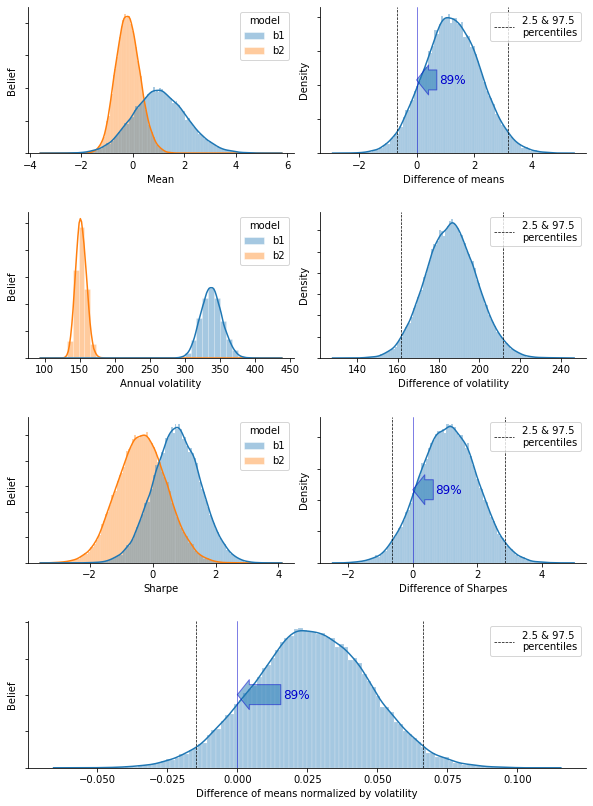

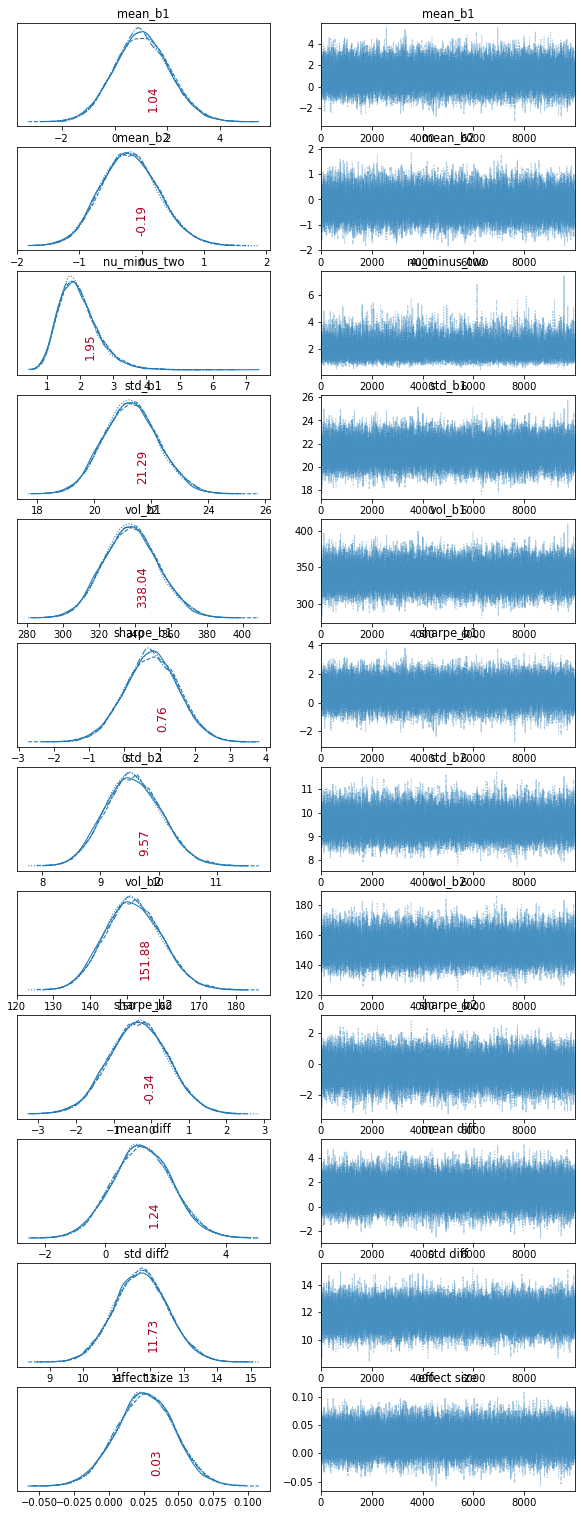

time: 10min 46s (started: 2023-02-28 12:20:47 +09:00)


In [194]:
# proba that strategy b1 outperforms b2 is 89%. but b1 is more volatile.
bayesian_estimate(df)

### CS02

In [195]:
df = df_compare.loc[df_compare.scenario.isin(['b1','t1a'])].reset_index().set_index(['scenario', 'start']).squeeze()

time: 28.9 ms (started: 2023-02-28 12:31:34 +09:00)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [std_t1a, mean_t1a, std_b1, mean_b1, nu_minus_two]


Sampling 4 chains for 2_500 tune and 10_000 draw iterations (10_000 + 40_000 draws total) took 587 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


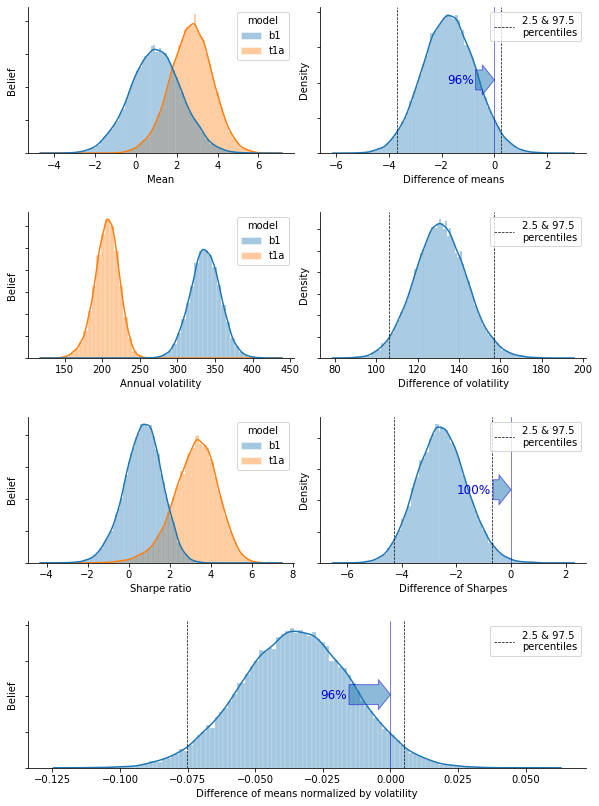

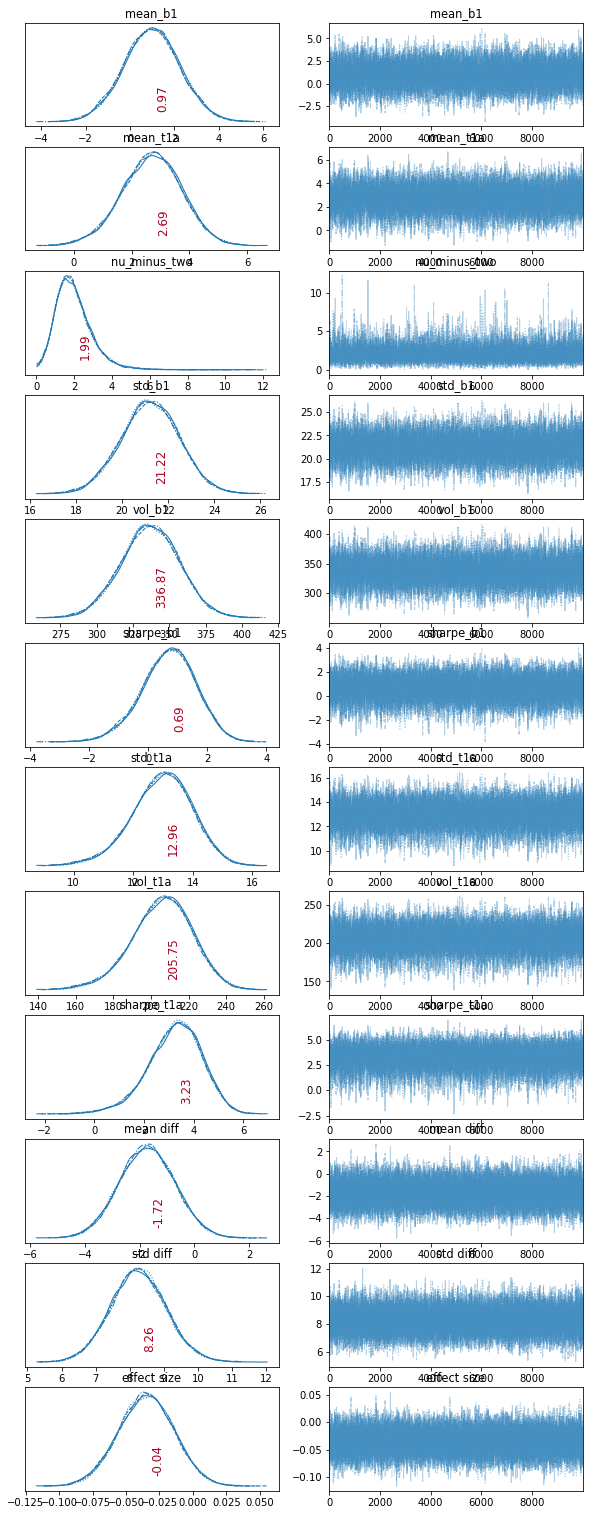

time: 13min (started: 2023-02-28 12:55:47 +09:00)


In [200]:
# t1a outperforms b1 in sharpe ratio and volatility as well.
bayesian_estimate(df)

# Longer Data Period

## Settings

Run settings in [Bayesian estimation](#Bayesian-estimation) for comparison

In [5]:
start = '20130101'
end = '20181231'
df_compare = pd.DataFrame()

time: 4.92 ms (started: 2023-03-01 18:19:05 +09:00)


In [72]:
start = '20030101'
end = '20131231'
df_compare = pd.DataFrame()

time: 2.16 ms (started: 2023-03-01 20:21:00 +09:00)


In [23]:
start = '20130101'
end = '20221231'
df_compare = pd.DataFrame()

time: 2.15 ms (started: 2023-03-01 18:30:53 +09:00)


In [73]:
symbol = '069500' # KODEX 200
df_all = fdr.DataReader(symbol, start, end)

time: 259 ms (started: 2023-03-01 20:21:02 +09:00)


In [74]:
df_bt_ori = (df_all.Close.rename_axis('dt').to_frame('close')
               .assign(custom=0))
dates_all = df_bt_ori.index

time: 12.9 ms (started: 2023-03-01 20:21:03 +09:00)


In [75]:
hold_period = 365
dates_start = df_bt_ori.loc[: dates_all[-1] - timedelta(hold_period)].index
n_dates = dates_start.size

time: 8.87 ms (started: 2023-03-01 20:21:04 +09:00)


In [76]:
dates_start

DatetimeIndex(['2003-01-02', '2003-01-03', '2003-01-06', '2003-01-07',
               '2003-01-08', '2003-01-09', '2003-01-10', '2003-01-13',
               '2003-01-14', '2003-01-15',
               ...
               '2012-12-13', '2012-12-14', '2012-12-17', '2012-12-18',
               '2012-12-20', '2012-12-21', '2012-12-24', '2012-12-26',
               '2012-12-27', '2012-12-28'],
              dtype='datetime64[ns]', name='dt', length=2486, freq=None)

time: 15.4 ms (started: 2023-03-01 20:21:05 +09:00)


In [77]:
kwargs_bt = {
    'init_cash': 1e7, 
    'commission': 0.00363960/100,
    'verbose': False, 
    'plot_bp':False,
    'buy_prop': 1,
    'sell_prop': 1,
    'upper_limit':0.1, 
    'lower_limit':-0.1
}

time: 1.08 ms (started: 2023-03-01 20:21:15 +09:00)


## Buy & Hold

In [78]:
df_bt = df_bt_ori.copy()

time: 7.52 ms (started: 2023-03-01 20:21:16 +09:00)


### CS01

In [109]:
scenario = 'b1'
n_buy = 1

kwargs_bt.update({
    'buy_prop': 1/n_buy,
})

time: 1.09 ms (started: 2023-03-01 10:32:14 +09:00)


In [110]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0

for i, start in enumerate(dates_start):
    df_bt['custom'] = 0 # reset
    df_bt.loc[start,'custom'] = -1
    
    res = run_backtest(start, df_bt, kwargs_bt)
    if res[2] <= 0:
        print('ERROR: no buy for buy&hold')
        break
    df_result.loc[i] = res
    
    n_last = print_progress(i, print_step, n_last)

10% done
20% done
30% done
40% done
50% done
60% done
70% done
80% done
90% done
100% done
time: 44min 15s (started: 2023-03-01 10:32:19 +09:00)


### CS02

In [79]:
scenario = 'b4'
n_buy = 5

kwargs_bt.update({
    'buy_prop': 1/n_buy,
})

time: 1.14 ms (started: 2023-03-01 20:21:31 +09:00)


In [80]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0

period = 40

for i, start in enumerate(dates_start):
    df_bt['custom'] = 0 # reset
    dt = dates_all[[i + x*period for x in range(n_buy)]]
    df_bt.loc[dt,'custom'] = -1
    
    res = run_backtest(start, df_bt, kwargs_bt)
    if res[2] <= 0:
        print('ERROR: no buy for buy&hold')
        break
    df_result.loc[i] = res
    n_last = print_progress(i, print_step, n_last)

10% done
20% done
30% done
40% done
50% done
60% done
70% done
80% done
90% done
100% done
time: 1h 4min 59s (started: 2023-03-01 20:21:33 +09:00)


In [81]:
df_result['return'].agg(['mean','min','max'])

mean     7.805935
min    -32.147372
max     34.243090
Name: return, dtype: float64

time: 14.3 ms (started: 2023-03-01 21:26:32 +09:00)


In [82]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 9.77 ms (started: 2023-03-01 21:26:32 +09:00)


## MACD

In [83]:
df_bt = df_bt_ori.copy()
df_macd = calc_macd(df_bt['close'])

time: 5.9 ms (started: 2023-03-01 21:26:32 +09:00)


In [84]:
df_ti = df_macd

cond = (df_ti.macd > df_ti.macd_signal) 
cond = cond & (df_ti.macd > 0)
df_bt.loc[cond, 'custom'] = -1

cond = (df_ti.macd < df_ti.macd_signal) 
cond = cond & (df_ti.macd < 0)
df_bt.loc[cond, 'custom'] = 1

time: 12.9 ms (started: 2023-03-01 21:26:32 +09:00)


In [85]:
df_bt = finish_custom(df_bt)

time: 781 ms (started: 2023-03-01 21:26:32 +09:00)


In [86]:
# small number of chance to buy
df_bt.custom.value_counts()

 0    2578
-1      91
 1      64
Name: custom, dtype: int64

time: 15.1 ms (started: 2023-03-01 21:26:33 +09:00)


### CS01

In [117]:
scenario = 't1a'

kwargs_bt.update({
    'buy_prop': 1,
    'sell_prop': 1
})

time: 1.01 ms (started: 2023-03-01 11:16:35 +09:00)


In [118]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0
idx_nobuy = []

for i, start in enumerate(dates_start):
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    n_last = print_progress(i, print_step, n_last)
    idx_nobuy = check_scenario(idx_nobuy, i, df_result)

check_scenario(idx_nobuy)

10% done
20% done
30% done
40% done
50% done
60% done
70% done
80% done
90% done
100% done
time: 1h 3min 47s (started: 2023-03-01 11:16:35 +09:00)


### CS02

In [64]:
#dates_start = df_bt.loc[:'2017-12-31'].index

time: 4.57 ms (started: 2023-03-01 19:34:21 +09:00)


In [87]:
scenario = 't1c'

kwargs_bt.update({
    'buy_prop': .2,
    'sell_prop': .2
})

time: 967 µs (started: 2023-03-01 21:26:33 +09:00)


In [88]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0
idx_nobuy = []

for i, start in enumerate(dates_start):
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    n_last = print_progress(i, print_step, n_last)
    idx_nobuy = check_scenario(idx_nobuy, i, df_result)

check_scenario(idx_nobuy)

10% done
20% done
30% done
40% done
50% done
60% done
70% done
80% done
90% done
100% done
time: 1h 35min 4s (started: 2023-03-01 21:26:33 +09:00)


In [89]:
df_result['return'].agg(['mean','min','max'])

mean     2.903185
min     -5.945416
max     22.941178
Name: return, dtype: float64

time: 27 ms (started: 2023-03-01 23:01:37 +09:00)


In [90]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 16.1 ms (started: 2023-03-01 23:01:37 +09:00)


In [91]:
#df_compare2.to_csv('df_compare2.csv')
#df_compare3.to_csv('df_compare3.csv')
#df_compare.to_csv('df_compare4.csv')
df_compare.to_csv('df_compare5.csv')

time: 167 ms (started: 2023-03-01 23:01:37 +09:00)


## Comparison

In [6]:
files = [f'df_compare{x}.csv' for x in [1,2,3,4,5]]
#files = [f'df_compare{x}.csv' for x in [2]]

df_compare = pd.DataFrame()
for f in files:
    df_compare = pd.concat([df_compare, pd.read_csv(f, parse_dates=['start'])])

df_compare = df_compare.drop_duplicates(subset=['scenario','start']).reset_index(drop=True)

time: 129 ms (started: 2023-03-01 23:19:00 +09:00)


In [7]:
df = df_compare.groupby('scenario')['start'].agg(['min','max','count'])
df

,min,max,count
scenario,,,
b1,2003-01-02,2021-12-29,4700
b2,2018-01-02,2021-12-29,985
b3,2018-01-02,2021-12-29,985
b4,2003-01-02,2021-12-29,4700
t1a,2003-01-02,2021-12-29,4700
t1b,2018-01-02,2021-12-29,985
t1c,2003-01-02,2021-12-29,4700
t1d,2018-01-02,2021-12-29,985
t2a,2018-01-02,2021-12-29,985


time: 56.3 ms (started: 2023-03-01 23:19:01 +09:00)


In [8]:
#models = df[df['min'].dt.year == 2013].index
#models = df[df['min'].dt.year == 2003].index
models = ['b4', 't1c']
models

['b4', 't1c']

time: 18.1 ms (started: 2023-03-01 23:19:17 +09:00)


In [12]:
df = df_compare.copy()
df = (df.loc[df.scenario.isin(models)]
        .dropna(subset='return')
        #.loc[df.start < '2018-01-01']
        .sort_values(by=['scenario'])
)

time: 37.5 ms (started: 2023-03-01 23:20:39 +09:00)


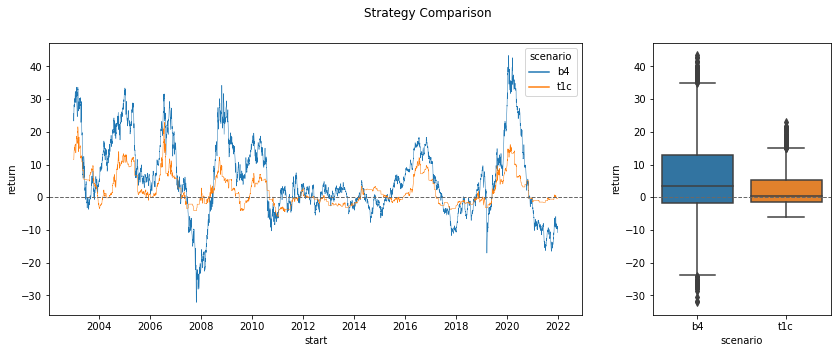

time: 1.86 s (started: 2023-03-01 23:20:48 +09:00)


In [14]:
compare_models(df)

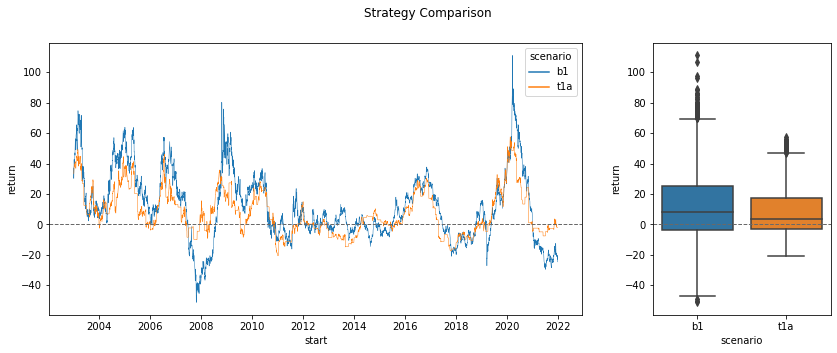

time: 1.67 s (started: 2023-03-01 14:20:43 +09:00)


In [ ]:
# for 19 yrs
compare_models(df)

In [15]:
df = df.set_index(['scenario', 'start']).squeeze()

time: 16 ms (started: 2023-03-01 23:21:01 +09:00)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [std_t1c, mean_t1c, std_b4, mean_b4, nu_minus_two]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 441 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


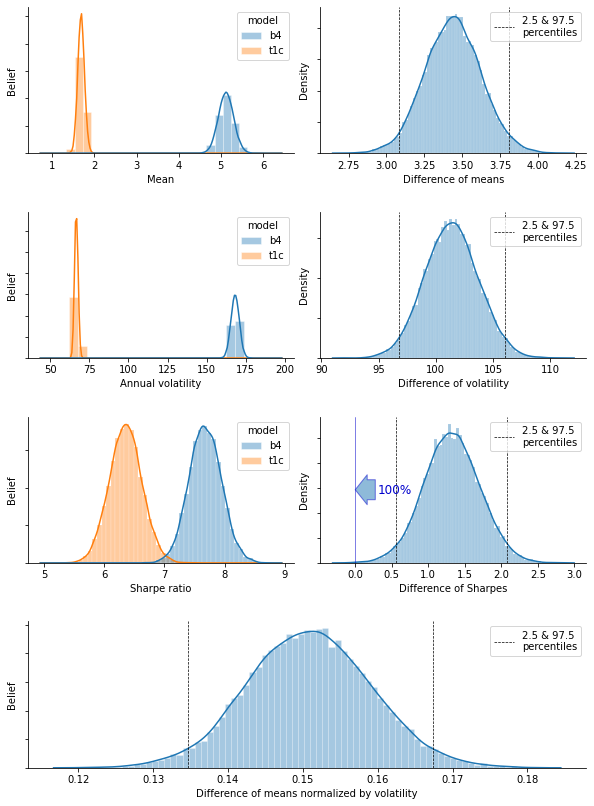

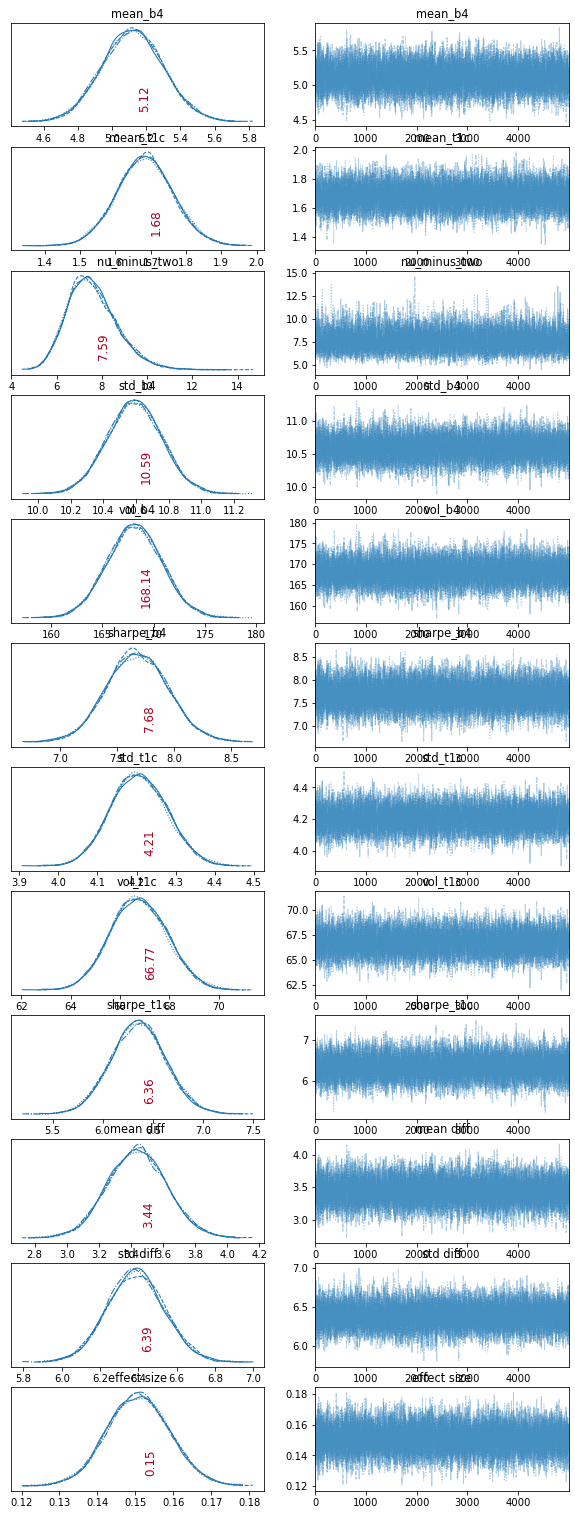

time: 10min 28s (started: 2023-03-01 23:21:02 +09:00)


In [16]:
bayesian_estimate(df, chains=4, draws=5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [std_t1a, mean_t1a, std_b1, mean_b1, nu_minus_two]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 323 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


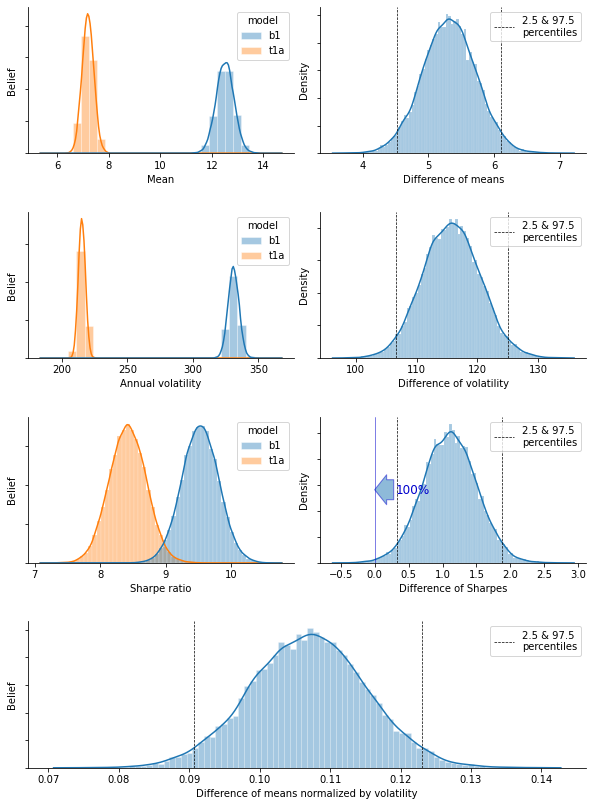

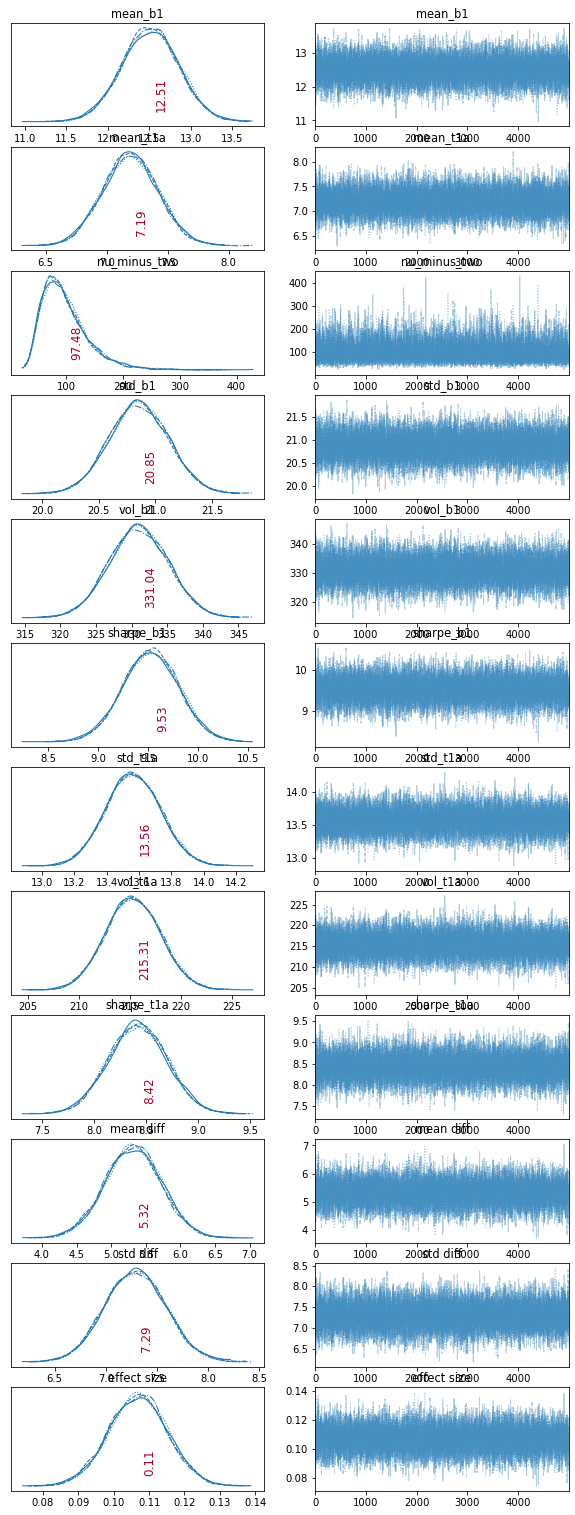

time: 7min 53s (started: 2023-03-01 14:08:36 +09:00)


In [13]:
# for 15 yrs
bayesian_estimate(df, chains=4, draws=5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [std_t1a, mean_t1a, std_b1, mean_b1, nu_minus_two]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 441 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


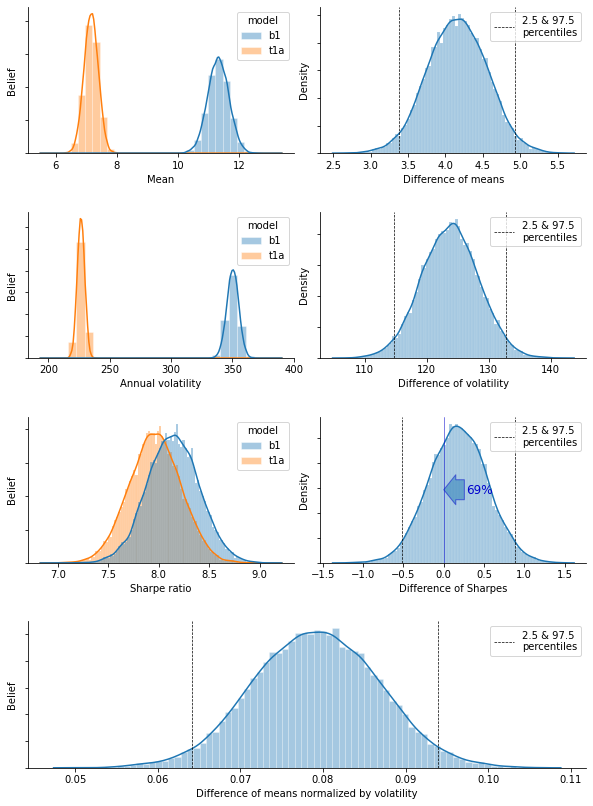

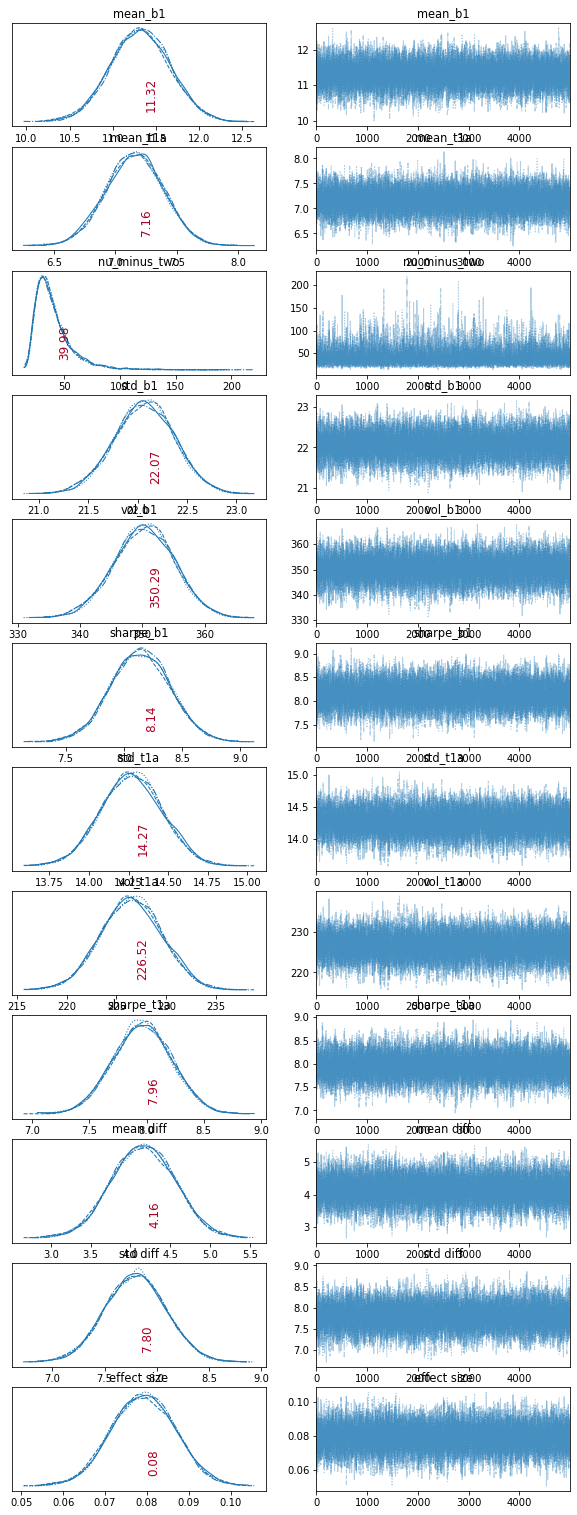

time: 10min 9s (started: 2023-03-01 14:21:10 +09:00)


In [17]:
# for 19 yrs
bayesian_estimate(df, chains=4, draws=5000, tune=1000)